In [1]:
import numpy as np
import pandas as pd
import random
import os
working_dir = "/Users/nkarisan/PycharmProjects/BTC_Cell_Line_Atlas_Manuscript"
os.chdir(working_dir)

from scripts.io_library import MyLib, output_dir
import scripts.io_library as io_library
from scripts.clustering_utils import Clustering
from scripts.visualization import MyVisualization
io_library.input_dir = 'input_data/'
io_library.output_dir = 'Figure1/output_fig1/'

In [2]:
import matplotlib
seed = 2023
random.seed(seed)
np.random.seed(seed)

matplotlib.use("nbagg")


%matplotlib inline
%config InlineBackend.figure_format = "retina"


%load_ext autoreload
%autoreload 2

In [3]:
upset_file = 'cell_lines_master_upset_2025-2-24.csv'
rna_btc_file = 'main_data/RNA/rna_cell_lines.csv'
depmap_rna_file = 'Additional_Data/DepMap/RNA_20Q2/CCLE_expression.csv'
depmap_sample_info_file = 'Additional_Data/DepMap/RNA_20Q2/sample_info.csv'

In [4]:
raw_upset_df = MyLib.load_csv(upset_file)
raw_upset_df.set_index('Cell_line', inplace=True, drop=True)
upset_df = raw_upset_df[(raw_upset_df['RNA']==1) & (raw_upset_df['Subtype']!='HCC')]

rna_btc_df = MyLib.load_csv(rna_btc_file, index_col=0).T
rna_btc_df = rna_btc_df.loc[upset_df.index]
print(f'rna_btc_df shape {rna_btc_df.shape}')


depmap_sample_info_df = MyLib.load_csv(depmap_sample_info_file, index_col=0)
depmap_sample_info_df = depmap_sample_info_df.loc[depmap_sample_info_df['lineage'].isin(["pancreas", "colorectal","gastric", "liver", "esophagus"])]

depmap_rna_df = MyLib.load_csv(depmap_rna_file, index_col=0)
depmap_rna_df = depmap_rna_df.rename(columns={col:col.split(' (')[0] for col in depmap_rna_df.columns})
depmap_rna_df = depmap_rna_df.loc[~depmap_rna_df.index.isin(upset_df['DepMap_ID'])]
depmap_rna_df = depmap_rna_df.loc[depmap_rna_df.index.isin(depmap_sample_info_df.index)]
depmap_sample_info_df = depmap_sample_info_df.loc[depmap_rna_df.index]
print(f'depmap_rna_df shape {depmap_rna_df.shape}')


input_data/cell_lines_master_upset_2025-2-24.csv  is loaded, shape:  (87, 12)

input_data/main_data/RNA/rna_cell_lines.csv  is loaded, shape:  (17649, 79)

rna_btc_df shape (56, 17649)
input_data/Additional_Data/DepMap/RNA_20Q2/sample_info.csv  is loaded, shape:  (1804, 23)

input_data/Additional_Data/DepMap/RNA_20Q2/CCLE_expression.csv  is loaded, shape:  (1305, 19144)

depmap_rna_df shape (216, 19144)


In [5]:
shared_l = sorted(set(depmap_rna_df.columns).intersection(rna_btc_df.columns))
depmap_rna_df = depmap_rna_df[shared_l].copy()
rna_btc_df = rna_btc_df[shared_l].copy()
exp_df = pd.concat([rna_btc_df, depmap_rna_df])
exp_df.shape

(272, 17649)

In [6]:
info_df = pd.concat([pd.DataFrame(['bile duct']*rna_btc_df.shape[0], index=rna_btc_df.index, columns=['lineage']), depmap_sample_info_df[['lineage']]])
info_df.columns = ['Lineage']
info_df

,Lineage
SNU869,bile duct
SNU478,bile duct
TGBC52TKB,bile duct
AOVC1,bile duct
SNU245,bile duct
...,...
ACH-000305,esophagus
ACH-000296,colorectal
ACH-000110,gastric
ACH-000031,pancreas


In [7]:
info_df.Lineage.value_counts()

colorectal    67
bile duct     56
pancreas      51
gastric       42
esophagus     32
liver         24
Name: Lineage, dtype: int64

In [8]:
exp_df.shape

(272, 17649)

In [9]:
exp_df2 = Clustering.drop_low_vars(exp_df, threshold=0.5)
exp_df2.shape

(272, 8938)

In [10]:
fold_exp_df = exp_df2.apply(lambda x:x-x.median())
corr_fold_exp_df = pd.DataFrame(np.corrcoef(fold_exp_df.values), columns=fold_exp_df.index, index=fold_exp_df.index)

# Clustering


File  Figure1/output_fig1/all_C1_features_Up.csv saved, shape: (2117, 4)

File  Figure1/output_fig1/C1_features_Up.csv saved, shape: (50, 3)

File  Figure1/output_fig1/all_C2_features_Up.csv saved, shape: (2951, 4)

File  Figure1/output_fig1/C2_features_Up.csv saved, shape: (50, 3)

File  Figure1/output_fig1/all_C3_features_Up.csv saved, shape: (2642, 4)

File  Figure1/output_fig1/C3_features_Up.csv saved, shape: (50, 3)

File  Figure1/output_fig1/all_C4_features_Up.csv saved, shape: (2486, 4)

File  Figure1/output_fig1/C4_features_Up.csv saved, shape: (50, 3)

File  Figure1/output_fig1/all_C5_features_Up.csv saved, shape: (1963, 4)

File  Figure1/output_fig1/C5_features_Up.csv saved, shape: (50, 3)

File  Figure1/output_fig1/all_C6_features_Up.csv saved, shape: (1696, 4)

File  Figure1/output_fig1/C6_features_Up.csv saved, shape: (50, 3)

File  Figure1/output_fig1/Gene_reordered_upset_df.csv saved, shape: (272, 2)


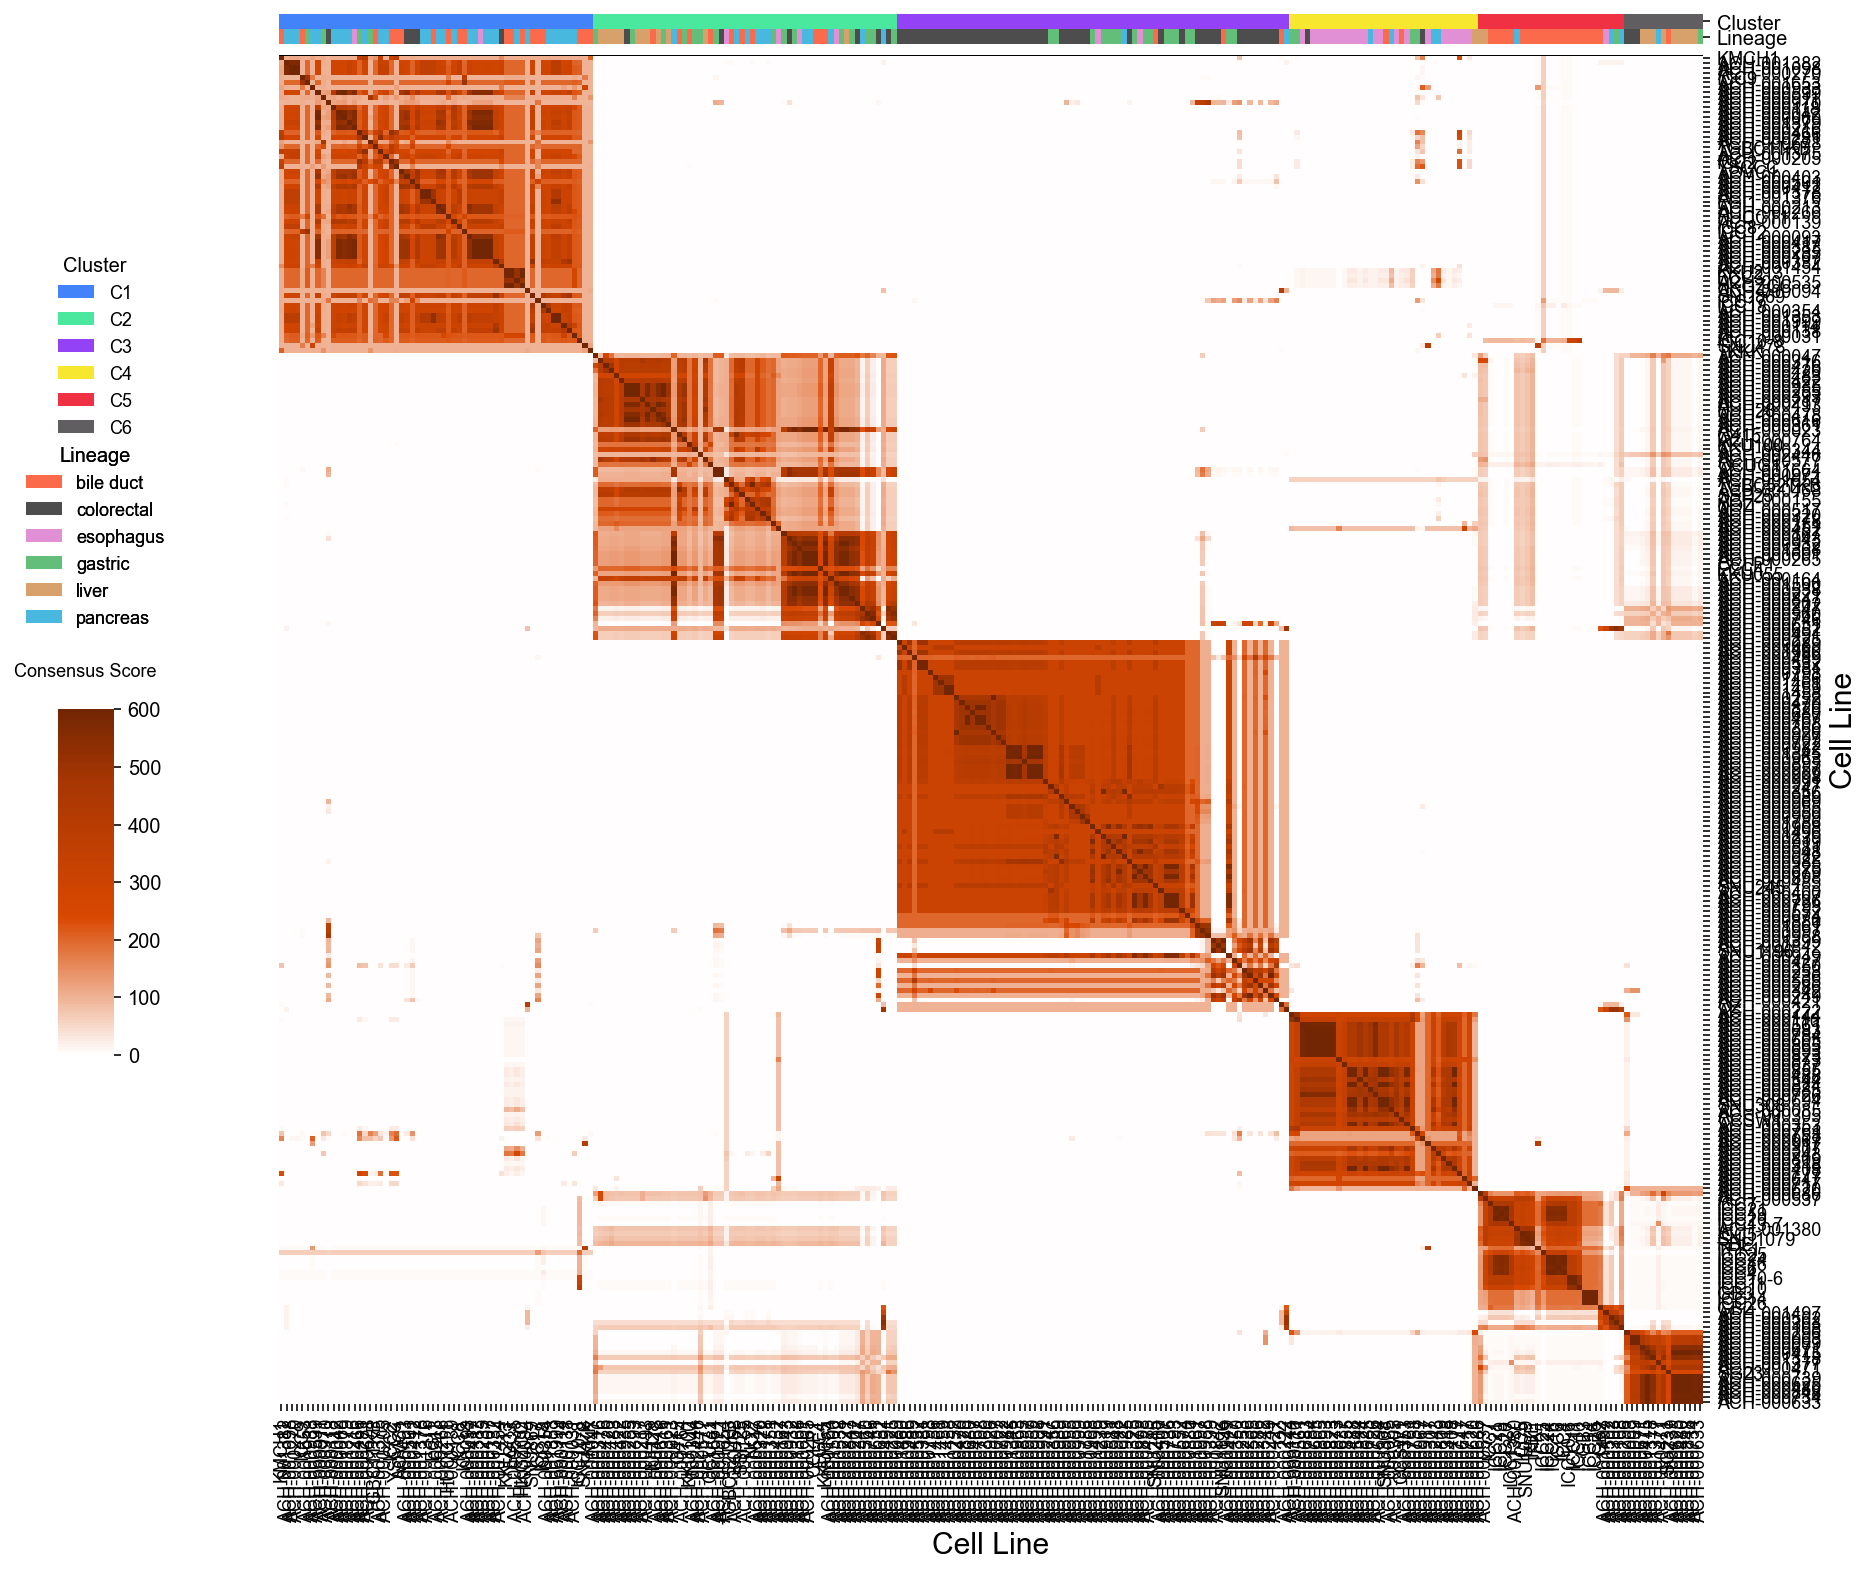

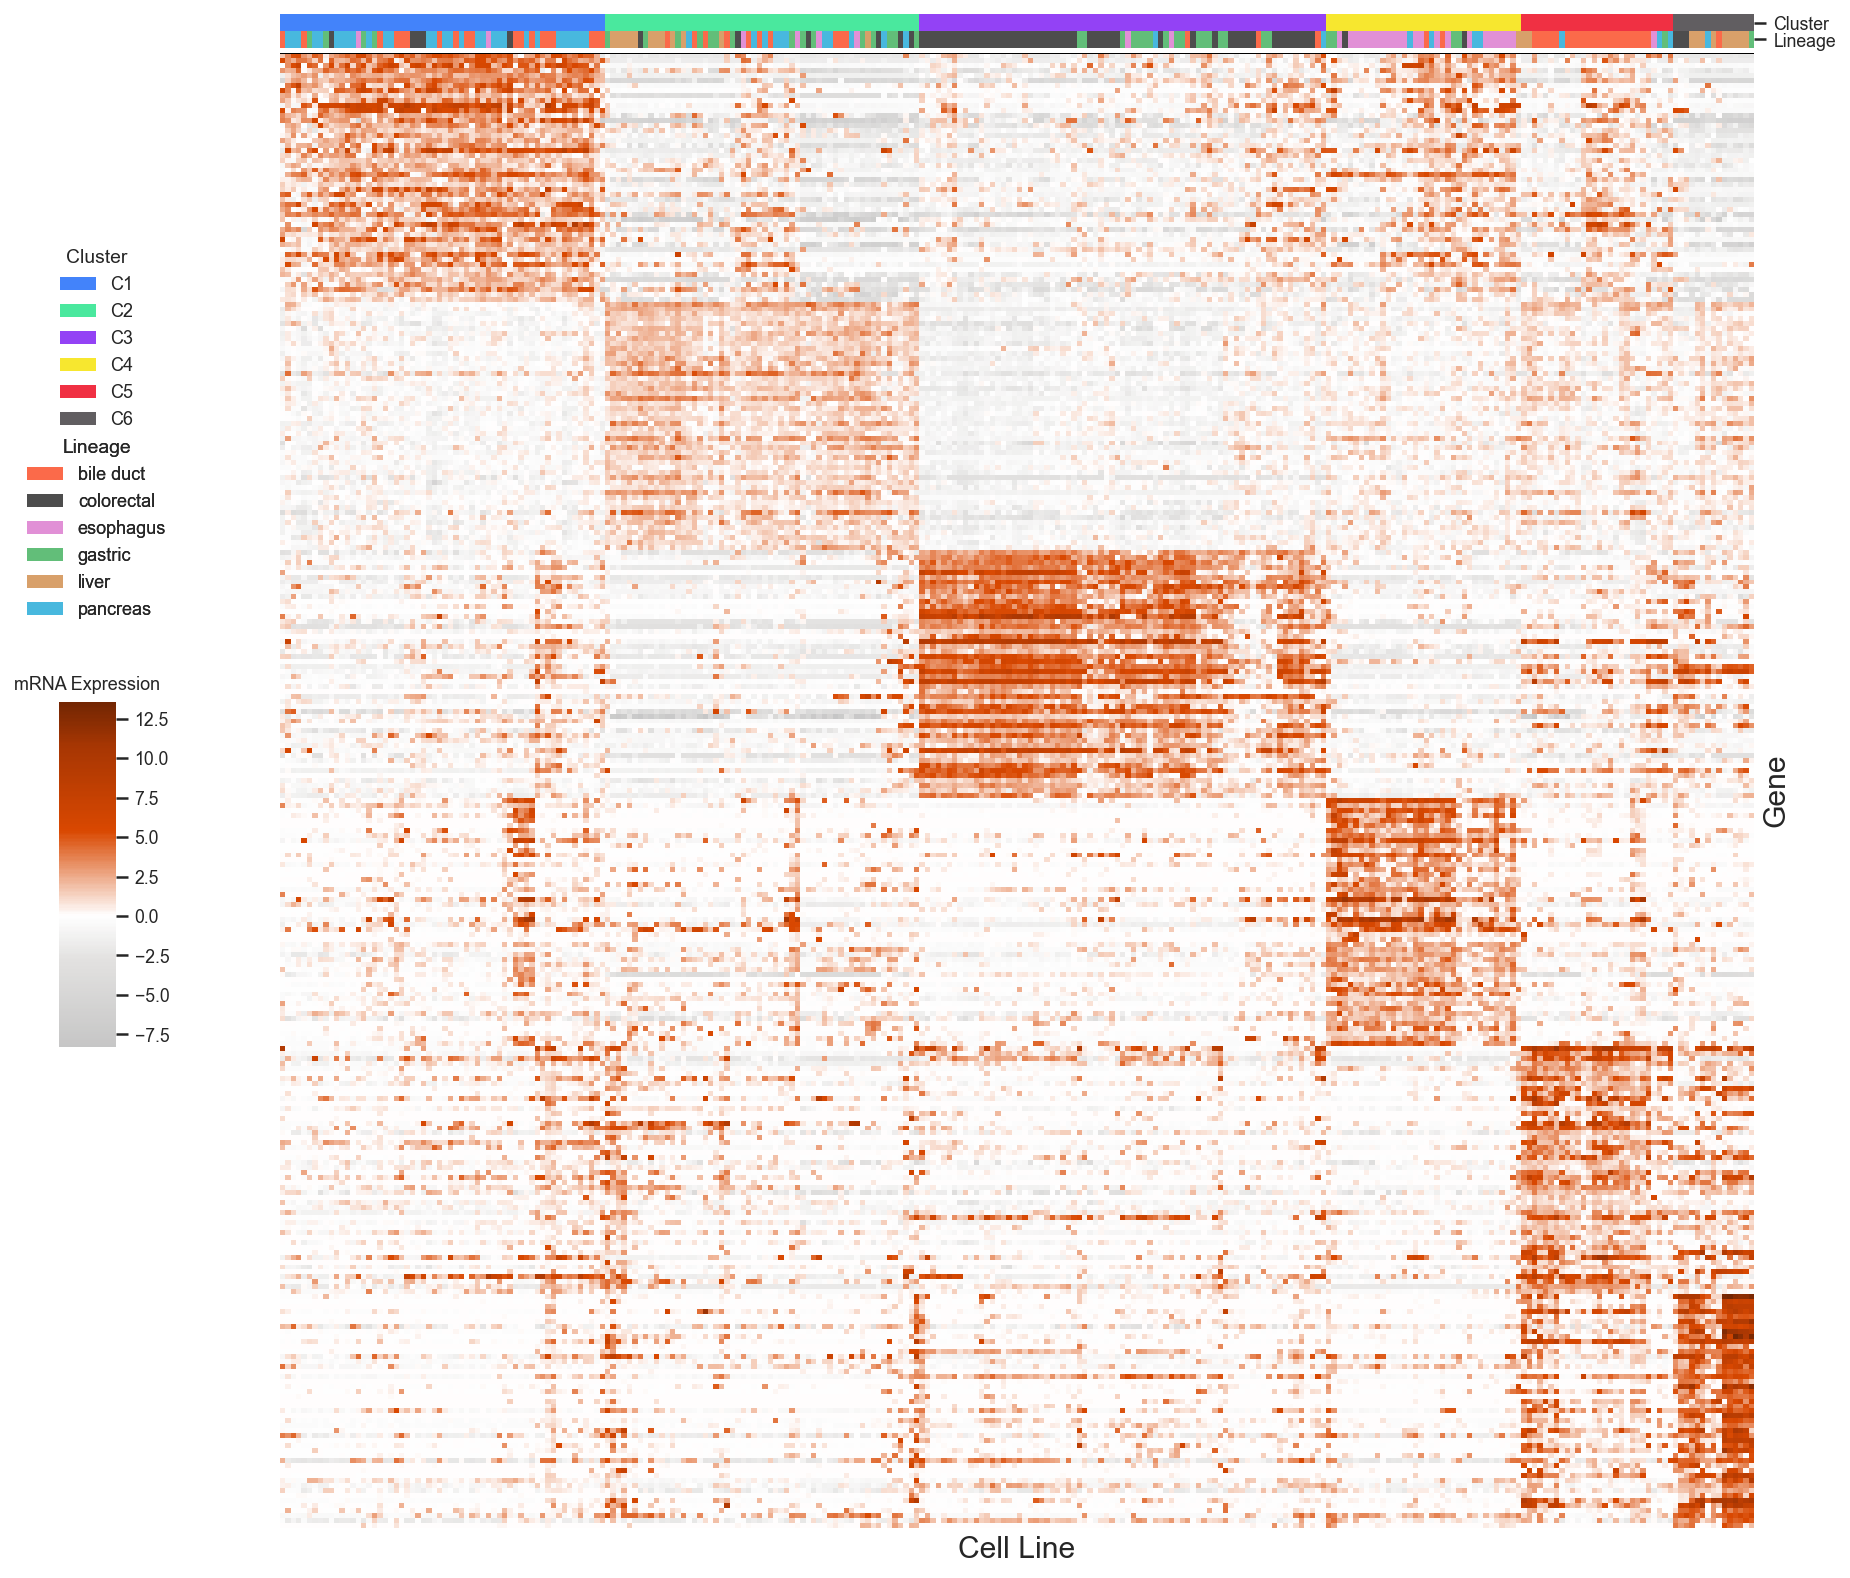

In [11]:
gammas =  [1.5, 2, 2.5, 3, 3.5, 4]
clusters_reordering = [1, 2, 3, 5, 4, 6]
# clusters_reordering = None
labels_np, consensus_ite = Clustering.louvain_clustering_ensemble(corr_fold_exp_df, gammas=gammas)
up_markers_df, new_info_df = Clustering.plot_consensus_heatmaps(fold_exp_df, corr_fold_exp_df, info_df, labels_np, consensus_ite, clusters_reordering=clusters_reordering, reverse=True,  bar_colors_ratio=0.01, feature_cutoff=50, yticklabels=False, xticklabels=False, event_legend=False, event_color='#8D0741',  cbar_title=f"mRNA Expression", cbar_left_adjust=0.04, left_adjust=0.07, legend_top_offset=0.7, borders_linewidths=0, clusters_type_filename='', save_figure=True)

In [12]:
# Create supplementary table for features
feat_file = '_features_Up.csv'
feat_df = pd.DataFrame()
for i in range(1, 7):
    df = pd.read_csv(io_library.output_dir+f'C{i}'+feat_file, index_col=0)
    df['Cluster'] = f'C{i}'
    feat_df = pd.concat([feat_df, df])
MyLib.save_csv(feat_df, 'GI_RNA_Cluster_signature.csv')


File  Figure1/output_fig1/GI_RNA_Cluster_signature.csv saved, shape: (300, 4)


# ARI analysis

C1
C2
C3
C4
C5
C6

File  Figure1/output_fig1/adjusted_rand_index_stats_RNA_depmap_GI_Clustering.csv saved, shape: (14, 6)

File  Figure1/output_fig1/adjusted_rand_scores_Clustering SimilaritiesRNA_depmap_GI_Clustering.csv saved, shape: (14, 6)


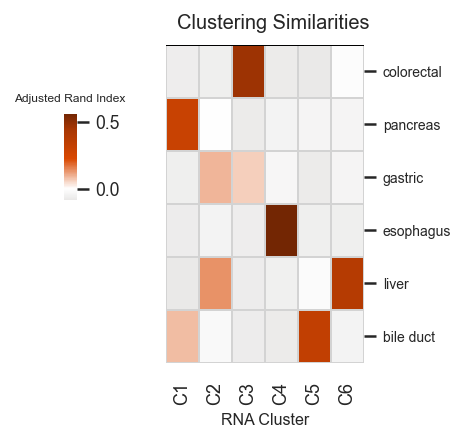

(                C1      C2      C3      C4      C5      C6
 colorectal  0.9998  0.9992  0.0002     1.0     1.0  0.7752
 pancreas    0.0002  0.5668     1.0  0.9334   0.925  0.9612
 gastric      0.994  0.0134  0.0406  0.8542  0.9918  0.9226
 esophagus   0.9974   0.945  0.9996  0.0002  0.9732     1.0
 liver          1.0   0.001     1.0  0.9704  0.7316  0.0002
 bile duct   0.0172   0.811     1.0  0.9996  0.0002   0.972,
                  C1        C2       C3       C4       C5       C6
 colorectal      1.0       1.0  0.00144      1.0      1.0      1.0
 pancreas    0.00144       1.0      1.0      1.0      1.0      1.0
 gastric         1.0  0.068914   0.1624      1.0      1.0      1.0
 esophagus       1.0       1.0      1.0  0.00144      1.0      1.0
 liver           1.0     0.006      1.0      1.0      1.0  0.00144
 bile duct    0.0774       1.0      1.0      1.0  0.00144      1.0)

In [13]:
RNA_upset_df = new_info_df

feat_df = pd.DataFrame(index=RNA_upset_df.index)
for f in feat_df.columns:
    feat_df[f] = feat_df[f].apply(lambda x:1 if x!=0 else 0)
for c in RNA_upset_df['Lineage'].unique():
    feat_df[c] = RNA_upset_df['Lineage'].apply(lambda x:1 if x==c else 0)
feats = ['colorectal', 'pancreas', 'gastric', 'esophagus', 'liver', 'bile duct']
feat_df = feat_df[feats]
clusters_df = pd.DataFrame(0, index=RNA_upset_df.index, columns=sorted(RNA_upset_df['Cluster'].unique()))
for c in clusters_df.columns:
    clusters_df[c] = RNA_upset_df['Cluster'].apply(lambda x:1 if x==c else 0)
# Clustering.clustering_scores(clusters_df, feat_df, split_row=[12], save_figure=True)
Clustering.clustering_scores_and_statistics(clusters_df, feat_df,  filename='RNA_depmap_GI_Clustering')

# UMAP

UMAP(local_connectivity=1, metric='precomputed', n_epochs=200, n_jobs=1, random_state=4241988, verbose=True)
Fri Apr 25 15:55:40 2025 Construct fuzzy simplicial set
Fri Apr 25 15:55:40 2025 Finding Nearest Neighbors
Fri Apr 25 15:55:44 2025 Finished Nearest Neighbor Search
Fri Apr 25 15:55:45 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Apr 25 15:55:46 2025 Finished embedding


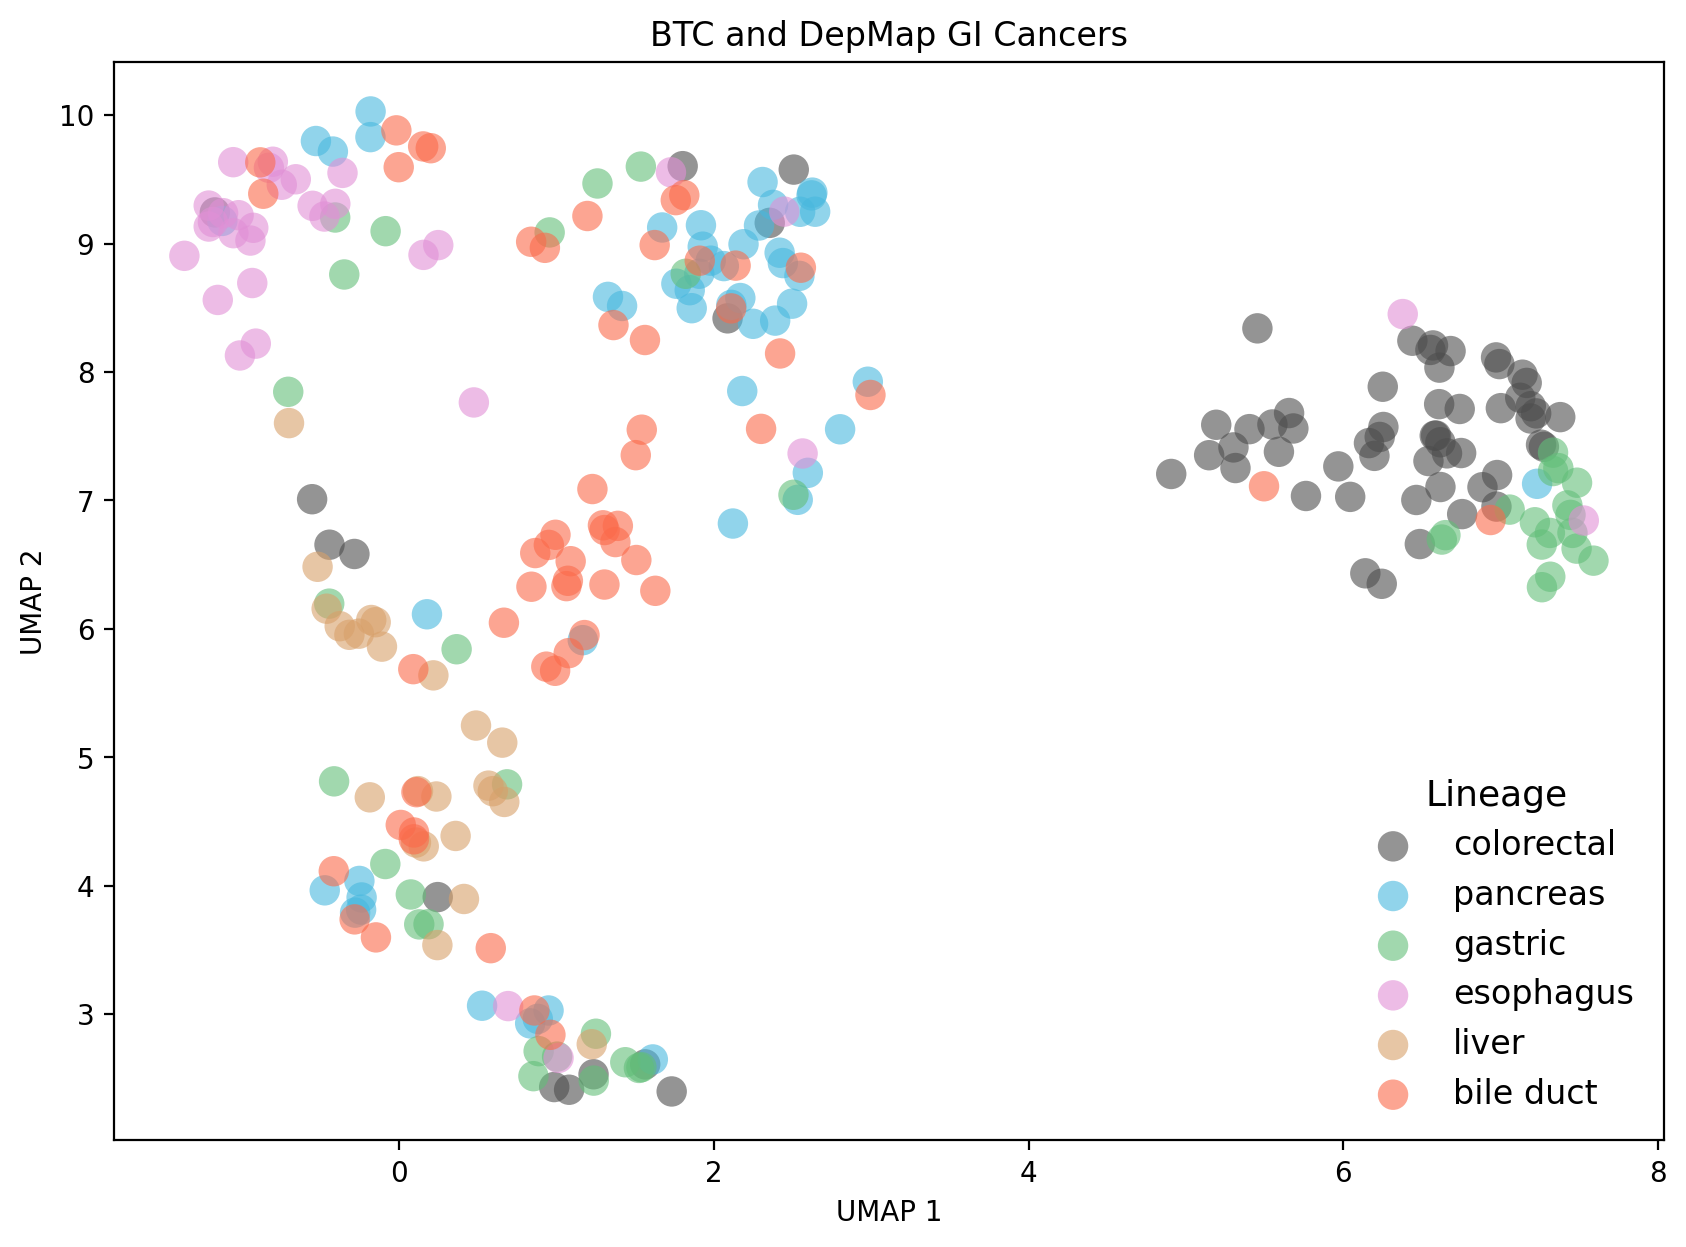

In [14]:
dist_df = 1- Clustering.normalize_corr_matrix(corr_fold_exp_df)
embd_df1 = MyVisualization.plot_umap(dist_df, info_df.loc[corr_fold_exp_df.index,'Lineage'], MyVisualization.feat_colors_dic['Lineage'], title='BTC and DepMap GI Cancers', groups_order_l=['colorectal', 'pancreas', 'gastric', 'esophagus', 'liver', 'bile duct'], point_size=120, metric="precomputed", legend_title='Lineage', file_name='umap_GI_lineages')

UMAP(local_connectivity=1, metric='precomputed', n_epochs=200, n_jobs=1, random_state=4241988, verbose=True)
Fri Apr 25 15:55:46 2025 Construct fuzzy simplicial set
Fri Apr 25 15:55:46 2025 Finding Nearest Neighbors
Fri Apr 25 15:55:46 2025 Finished Nearest Neighbor Search
Fri Apr 25 15:55:46 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Apr 25 15:55:46 2025 Finished embedding


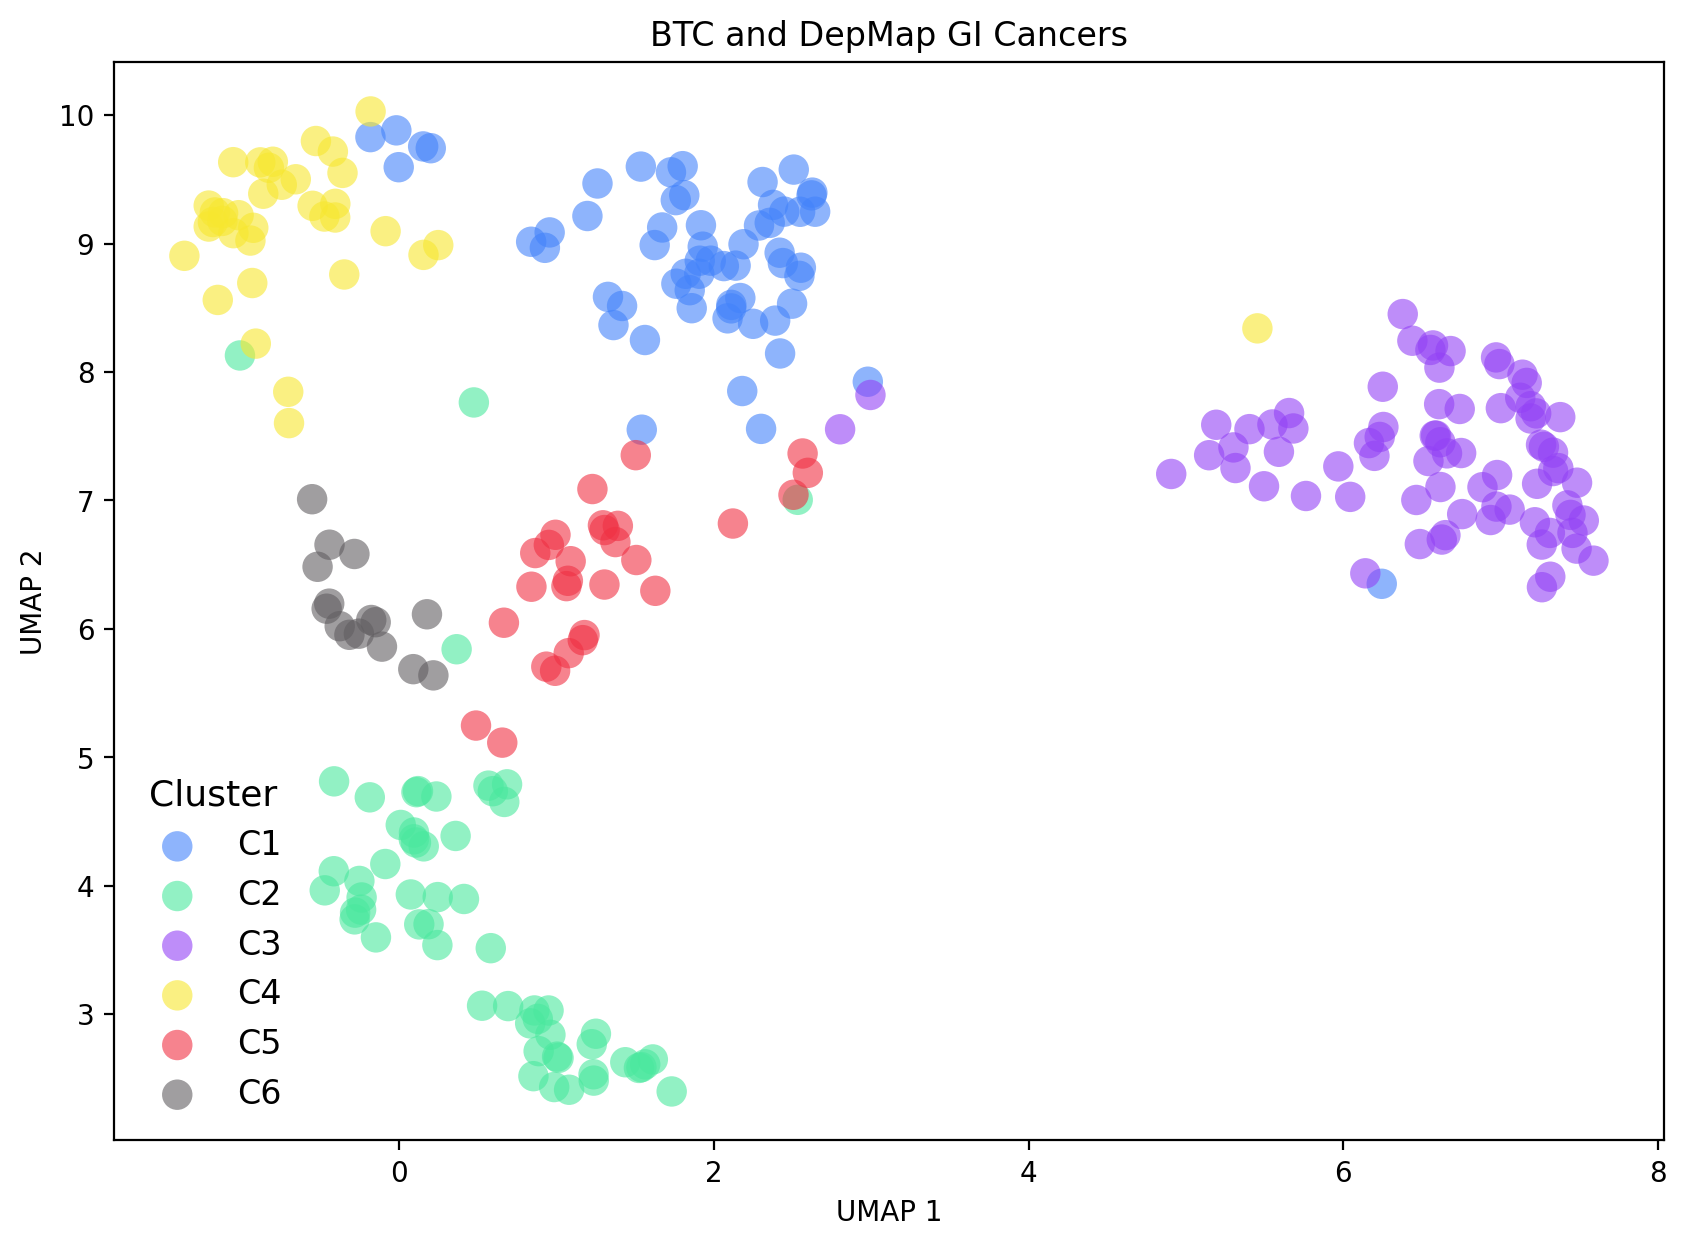

In [15]:
dist_df = 1- Clustering.normalize_corr_matrix(corr_fold_exp_df)
embd_df2 = MyVisualization.plot_umap(dist_df, new_info_df.loc[corr_fold_exp_df.index,'Cluster'], MyVisualization.feat_colors_dic['Cluster'], title='BTC and DepMap GI Cancers',  point_size=120, metric="precomputed", legend_title='Cluster', file_name='umap_GI_clusters')#, groups_order_l=['C1', 'C3','C4','C5','C6', 'C2']

In [16]:
embd_df1.head()

,UMAP1,UMAP2
SNU869,2.553041,8.812127
SNU478,-0.002550,9.594898
TGBC52TKB,-0.415171,4.113000
AOVC1,1.758212,9.338423
SNU245,6.936161,6.847641


In [17]:
embd_df2.head()

,UMAP1,UMAP2
SNU869,2.553041,8.812127
SNU478,-0.002550,9.594898
TGBC52TKB,-0.415171,4.113000
AOVC1,1.758212,9.338423
SNU245,6.936161,6.847641


In [18]:
embd_df1['Lineage'] = info_df.loc[corr_fold_exp_df.index,'Lineage']
embd_df1['Cluster'] = new_info_df.loc[corr_fold_exp_df.index,'Cluster']
embd_df1 = embd_df1[['Lineage', 'Cluster', 'UMAP1', 'UMAP2']]
MyLib.save_csv(embd_df1, 'UMAP_GI_Clustering.csv')


File  Figure1/output_fig1/UMAP_GI_Clustering.csv saved, shape: (272, 4)


# TCGA UMAP

Include a subtype column and extract the data points displayed in the zoomed-in plot.

In [18]:
tcga_umap_file = 'Figure1/output_fig1/UMAP_TCGA_DepMap_GI_flat.csv'
tcga_umap = pd.read_csv(tcga_umap_file, index_col=0)

In [19]:
tcga_umap['Subtype'] = np.nan
share = list(set(tcga_umap.index).intersection(raw_upset_df.index))
tcga_umap.loc[share, 'Subtype'] = raw_upset_df.loc[share, 'Subtype']

In [20]:
filtered_df = tcga_umap[(tcga_umap['UMAP1'] > -0.2) & (tcga_umap['UMAP1'] < 0.3)]
filtered_df = filtered_df[(filtered_df['UMAP2'] > -5.4) & (filtered_df['UMAP2'] < -3.7)]
tcga_umap['in_zoomed_plot'] = np.nan
tcga_umap.loc[filtered_df.index, 'in_zoomed_plot'] = 1
MyLib.save_csv(tcga_umap, 'UMAP_TCGA_DepMap_GI_flat2.csv')


File  Figure1/output_fig1/UMAP_TCGA_DepMap_GI_flat2.csv saved, shape: (2239, 6)
